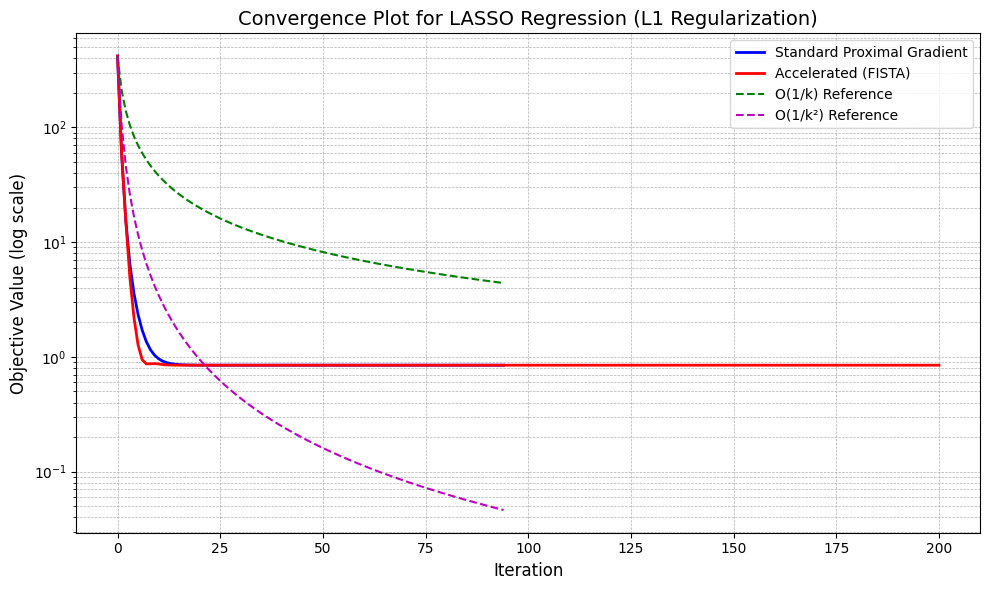

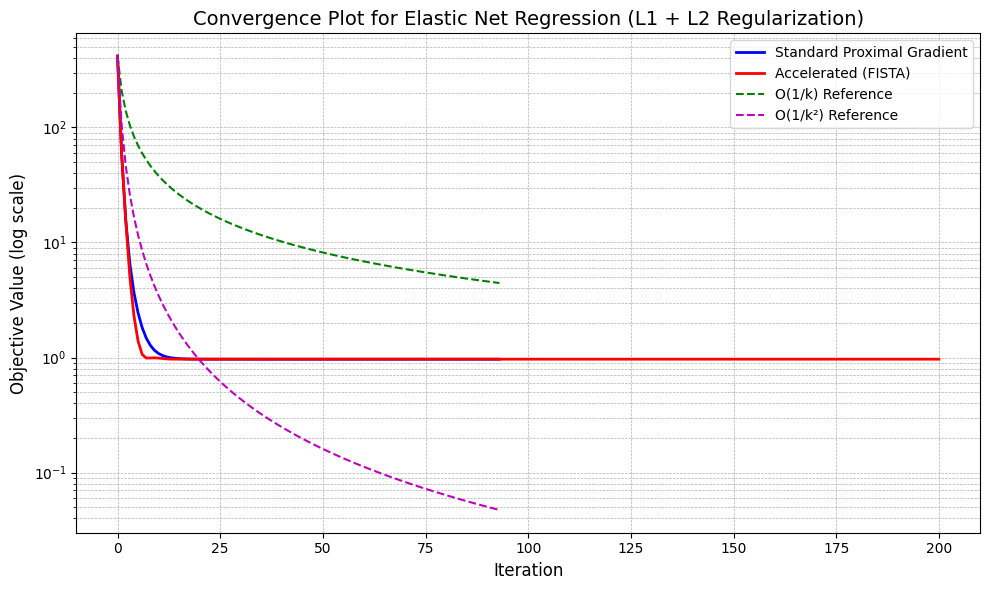

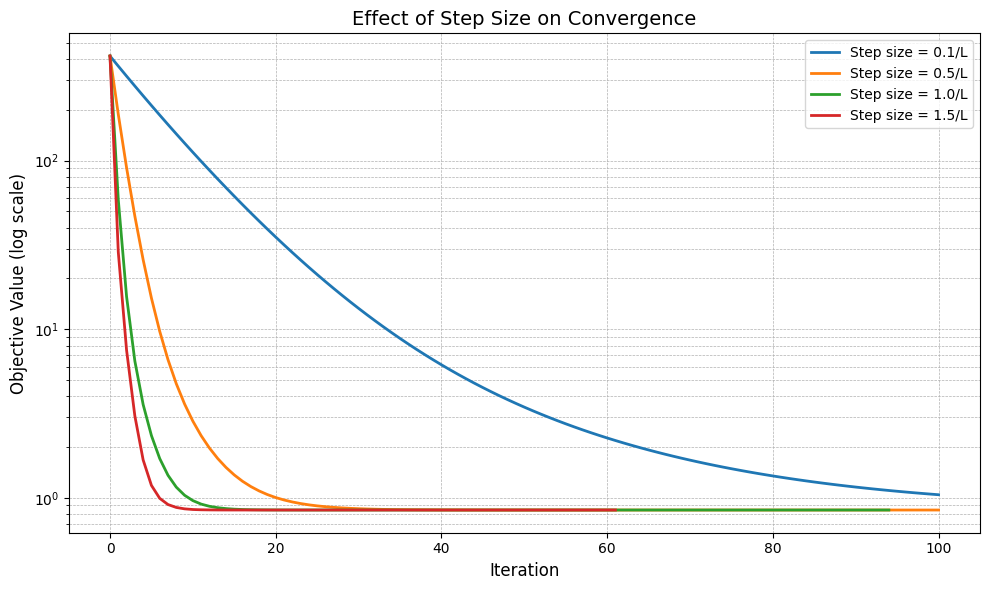

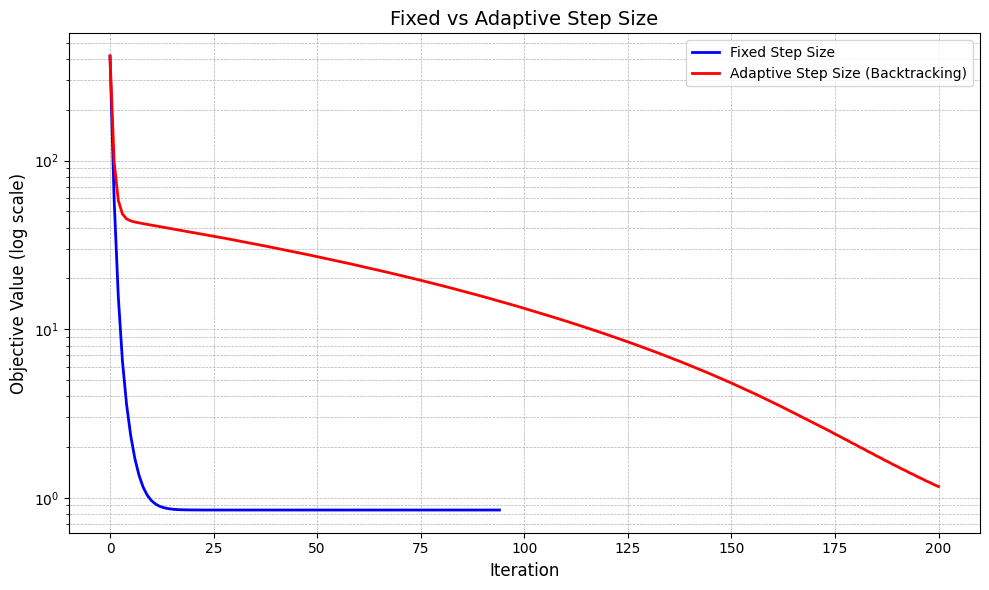

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from proximal import ProximalGradient, soft_thresholding, proximal_elastic_net

def plot_convergence(problem_type='lasso'):
    """
    Plot convergence of proximal gradient methods on a specified problem type.
    
    Parameters:
    -----------
    problem_type : str
        Type of problem to solve: 'lasso', 'ridge', 'elastic_net'
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate synthetic data
    n_samples, n_features = 100, 20
    X = np.random.randn(n_samples, n_features)
    
    # Create sparse ground truth
    w_true = np.zeros(n_features)
    w_true[:3] = [1.5, -0.8, 2.0]
    
    # Generate target with some noise
    y = X.dot(w_true) + 0.1 * np.random.randn(n_samples)
    
    # Common setup for all problems
    f = lambda w: 0.5 * np.sum((X.dot(w) - y) ** 2)
    grad = lambda w: X.T.dot(X.dot(w) - y)
    L = np.linalg.norm(X, ord=2)**2  # Lipschitz constant
    step_size = 1.0 / L
    max_iter = 200
    
    # Problem-specific proximal operators
    if problem_type == 'lasso':
        alpha = 0.1
        prox_op = lambda w, t: soft_thresholding(w, alpha * t)
        title = "LASSO Regression (L1 Regularization)"
        
    elif problem_type == 'ridge':
        alpha = 0.1
        prox_op = lambda w, t: w / (1 + 2 * alpha * t)
        title = "Ridge Regression (L2 Regularization)"
        
    elif problem_type == 'elastic_net':
        alpha_l1, alpha_l2 = 0.05, 0.05
        prox_op = lambda w, t: proximal_elastic_net(w, t, alpha_l1, alpha_l2)
        title = "Elastic Net Regression (L1 + L2 Regularization)"
    else:
        raise ValueError("Unknown problem type")
    
    # Create the optimizers (standard and accelerated)
    pg_standard = ProximalGradient(
        f_smooth=f,
        grad_smooth=grad,
        proximal_op=prox_op,
        step_size=step_size,
        max_iter=max_iter,
        tol=1e-10,
        accelerated=False
    )
    
    pg_accelerated = ProximalGradient(
        f_smooth=f,
        grad_smooth=grad,
        proximal_op=prox_op,
        step_size=step_size,
        max_iter=max_iter,
        tol=1e-10,
        accelerated=True
    )
    
    # Define a function to compute the objective value
    if problem_type == 'lasso':
        def objective(w):
            return f(w) + alpha * np.sum(np.abs(w))
    elif problem_type == 'ridge':
        def objective(w):
            return f(w) + alpha * np.sum(w**2)
    else:  # elastic_net
        def objective(w):
            return f(w) + alpha_l1 * np.sum(np.abs(w)) + alpha_l2 * np.sum(w**2)
    
    # Run optimization and collect trajectories
    x0 = np.zeros(n_features)
    w_std, _, traj_std = pg_standard.optimize(x0, return_iterations=True, return_trajectory=True)
    w_acc, _, traj_acc = pg_accelerated.optimize(x0, return_iterations=True, return_trajectory=True)
    
    # Compute objective values along trajectories
    obj_std = [objective(w) for w in traj_std]
    obj_acc = [objective(w) for w in traj_acc]
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.semilogy(obj_std, 'b-', linewidth=2, label='Standard Proximal Gradient')
    plt.semilogy(obj_acc, 'r-', linewidth=2, label='Accelerated (FISTA)')
    
    # Add reference line showing O(1/k) convergence rate
    k = np.arange(1, len(obj_std) + 1)
    reference = obj_std[0] / k
    plt.semilogy(reference, 'g--', linewidth=1.5, label='O(1/k) Reference')
    
    # Add reference line showing O(1/k²) convergence rate
    reference_k2 = obj_std[0] / (k**2)
    plt.semilogy(reference_k2, 'm--', linewidth=1.5, label='O(1/k²) Reference')
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Objective Value (log scale)', fontsize=12)
    plt.title(f'Convergence Plot for {title}', fontsize=14)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    return plt.gcf()

def compare_step_sizes():
    """
    Compare convergence for different step sizes.
    """
    np.random.seed(42)
    
    # Generate synthetic data
    n_samples, n_features = 100, 20
    X = np.random.randn(n_samples, n_features)
    w_true = np.zeros(n_features)
    w_true[:3] = [1.5, -0.8, 2.0]
    y = X.dot(w_true) + 0.1 * np.random.randn(n_samples)
    
    # Problem setup
    f = lambda w: 0.5 * np.sum((X.dot(w) - y) ** 2)
    grad = lambda w: X.T.dot(X.dot(w) - y)
    alpha = 0.1
    prox_op = lambda w, t: soft_thresholding(w, alpha * t)
    
    # Objective function
    def objective(w):
        return f(w) + alpha * np.sum(np.abs(w))
    
    # Lipschitz constant
    L = np.linalg.norm(X, ord=2)**2
    
    # Step sizes to try (as fractions of 1/L)
    step_fractions = [0.1, 0.5, 1.0, 1.5]
    max_iter = 100
    
    plt.figure(figsize=(10, 6))
    
    for frac in step_fractions:
        step_size = frac / L
        label = f'Step size = {frac}/L'
        
        pg = ProximalGradient(
            f_smooth=f,
            grad_smooth=grad,
            proximal_op=prox_op,
            step_size=step_size,
            max_iter=max_iter,
            tol=1e-10,
            accelerated=False
        )
        
        # Run optimization and collect trajectory
        x0 = np.zeros(n_features)
        _, _, traj = pg.optimize(x0, return_iterations=True, return_trajectory=True)
        
        # Compute objective values
        obj_values = [objective(w) for w in traj]
        
        # Plot
        plt.semilogy(obj_values, linewidth=2, label=label)
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Objective Value (log scale)', fontsize=12)
    plt.title('Effect of Step Size on Convergence', fontsize=14)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    return plt.gcf()

def adaptive_vs_fixed_step():
    """
    Compare fixed step size vs. adaptive (backtracking line search).
    """
    np.random.seed(42)
    
    # Generate synthetic data
    n_samples, n_features = 100, 20
    X = np.random.randn(n_samples, n_features)  
    w_true = np.zeros(n_features)
    w_true[:3] = [1.5, -0.8, 2.0]
    y = X.dot(w_true) + 0.1 * np.random.randn(n_samples)
    
    # Problem setup
    f = lambda w: 0.5 * np.sum((X.dot(w) - y) ** 2)
    grad = lambda w: X.T.dot(X.dot(w) - y)
    alpha = 0.1
    prox_op = lambda w, t: soft_thresholding(w, alpha * t)
    
    # Objective function
    def objective(w):
        return f(w) + alpha * np.sum(np.abs(w))
    
    # Lipschitz constant and step size
    L = np.linalg.norm(X, ord=2)**2
    step_size = 1.0 / L
    max_iter = 200
    
    # Run with fixed step size
    pg_fixed = ProximalGradient(
        f_smooth=f,
        grad_smooth=grad,
        proximal_op=prox_op,
        step_size=step_size,
        max_iter=max_iter,
        tol=1e-10,
        accelerated=False,
        adaptive_step_size=False
    )
    
    # Run with adaptive step size
    pg_adaptive = ProximalGradient(
        f_smooth=f,
        grad_smooth=grad,
        proximal_op=prox_op,
        step_size=step_size * 2,  # Start with a larger step size
        max_iter=max_iter,
        tol=1e-10,
        accelerated=False,
        adaptive_step_size=True
    )
    
    # Initial point
    x0 = np.zeros(n_features)
    
    # Run optimizations
    _, _, traj_fixed = pg_fixed.optimize(x0, return_iterations=True, return_trajectory=True)
    _, _, traj_adaptive = pg_adaptive.optimize(x0, return_iterations=True, return_trajectory=True)
    
    # Compute objective values
    obj_fixed = [objective(w) for w in traj_fixed]
    obj_adaptive = [objective(w) for w in traj_adaptive]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.semilogy(obj_fixed, 'b-', linewidth=2, label='Fixed Step Size')
    plt.semilogy(obj_adaptive, 'r-', linewidth=2, label='Adaptive Step Size (Backtracking)')
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Objective Value (log scale)', fontsize=12)
    plt.title('Fixed vs Adaptive Step Size', fontsize=14)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    return plt.gcf()

if __name__ == "__main__":
    # Plot convergence for LASSO problem
    fig1 = plot_convergence(problem_type='lasso')
    fig1.savefig('lasso_convergence.png')
    
    # Plot convergence for elastic net problem
    fig2 = plot_convergence(problem_type='elastic_net')
    fig2.savefig('elastic_net_convergence.png')
    
    # Compare different step sizes
    fig3 = compare_step_sizes()
    fig3.savefig('step_size_comparison.png')
    
    # Compare fixed vs adaptive step size
    fig4 = adaptive_vs_fixed_step()
    fig4.savefig('adaptive_step_size.png')
    
    plt.show()